# DAT200 CA4 2023

Kaggle username: aarondeleyos

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier

### Reading data

In [2]:
training_data = pd.read_csv(r'data\train.csv') # Load training data
training_data = training_data.drop('index', axis=1) # remove 'index' column

### Data exploration and visualisation

In [3]:
training_data.isna().sum() # check for missing values in the data set.

N_Days            0
Status            0
Drug              0
Age               0
Sex               0
Ascites           0
Hepatomegaly      0
Spiders           0
Edema             0
Bilirubin         0
Cholesterol      16
Albumin           0
Copper            1
Alk_Phos          0
SGOT              0
Tryglicerides    16
Platelets         4
Prothrombin       0
Stage             0
dtype: int64

In [4]:
# correlation_matrix = training_data.corr()
# fig_corr, ax_corr = plt.subplots(figsize=(16, 9))
# sns.heatmap(data=correlation_matrix, annot=True, ax=ax_corr)
# plt.show()

In [5]:
# # Pair plot
# plt.figure(figsize=(16, 9))
# sns.pairplot(data=training_data, hue='Stage', palette='Set1')
# plt.show()

### Data cleaning

In [6]:
# remove rows with nan values.
na_df = training_data.isna().sum()
nan_columns = pd.DataFrame(na_df[na_df != 0]).T.columns.tolist() # return column name if it contains nan-values

training_data = training_data.dropna(subset=nan_columns, axis=0) # remove nan-values

### Data exploration after cleaning

In [7]:
# # Pair plot after cleaning
# plt.figure(figsize=(16, 9))
# sns.pairplot(data=training_data, hue='Stage', palette='Set1')
# plt.show()

### Data preprocessing

In [8]:
training_data = pd.get_dummies(training_data, drop_first=True) # Convert nominal categorical values to numerical values
training_data['Stage'].value_counts() # Check number of data represented by each class

3    77
4    62
2    34
1     6
Name: Stage, dtype: int64

In [9]:
# we want to have as many data points as class 2, thus we subtract the number of data points of class 1
num_resamples = training_data[training_data['Stage'] == 2].shape[0] -\
                training_data[training_data['Stage'] == 1].shape[0] 

upsample = resample(training_data[training_data['Stage'] == 1], # Resample such that the dataset is more balanced
                    replace=True,
                    n_samples=num_resamples,
                    random_state=5151)

In [10]:
training_data_bal = pd.concat([training_data, upsample]) # add the upsampled values to the training_data
training_data_bal.index = list(range(training_data_bal.shape[0])) # Correct the indicies
training_data_bal['Stage'].value_counts() # Check that class 1 and 2 now have the same number of data points

3    77
4    62
2    34
1    34
Name: Stage, dtype: int64

#### Train test split

In [11]:
# Split dataset into X (data) and y (target)
X = training_data_bal.copy()
y = X['Stage']
X = X.drop('Stage', axis=1)

In [12]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=5413)

#### Scaling

In [13]:
sc = StandardScaler() # initialize a StandardScaler, then fit it to the training portion of the data.
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [14]:
# PCA application to check the principal components
num_comp = X.shape[1]
pca = PCA(n_components=num_comp)
X_train_pca = pca.fit_transform(X_train_std)
explVars = pca.explained_variance_ratio_

for i, cumsum in enumerate(np.cumsum(explVars), start=1):
    print(f'{i}) \t {cumsum:.4f}')

1) 	 0.2913
2) 	 0.3906
3) 	 0.4707
4) 	 0.5356
5) 	 0.5967
6) 	 0.6490
7) 	 0.6990
8) 	 0.7457
9) 	 0.7830
10) 	 0.8187
11) 	 0.8500
12) 	 0.8802
13) 	 0.9049
14) 	 0.9280
15) 	 0.9469
16) 	 0.9638
17) 	 0.9779
18) 	 0.9882
19) 	 0.9963
20) 	 1.0000


### Modelling

#### Data pipeline with kernel

In [15]:
pipe_svm = make_pipeline(StandardScaler(),
                         PCA(n_components=X.shape[1]),
                         SVC(random_state=359))

##### Randomized grid search setup (switch to normal grid search)

In [16]:
state = 761

inner_segments = 15
outer_segments = 15

c_range_svm = loguniform(1e-5, 400) # loguniform distribution which we can draw values from
gamma_range = loguniform(1e-4, 96) 

# Parameter grid for the SVC
svc_grid = [{'svc__C': c_range_svm.rvs(20), # draw 20 values from the distribution
            'svc__gamma': gamma_range.rvs(20), 
            'svc__kernel': ['linear', 'rbf'],
            'svc__class_weight': [None, 'balanced']}]

n_iter_search = 100 # number of parameter settings tested in the grid search

# Randomized grid search 
gs_svc = RandomizedSearchCV(estimator=pipe_svm,
                            param_distributions=svc_grid,
                            scoring='accuracy', n_iter=n_iter_search,
                            cv=inner_segments, n_jobs=-1)

# Cross validation
scores_nested_svm = cross_val_score(gs_svc, X_train, y_train,
                                    scoring='accuracy', cv=outer_segments)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_nested_svm),
                                      np.std(scores_nested_svm)))

CV accuracy: 0.934 +/- 0.089


In [17]:
svc_gc = gs_svc.fit(X_train, y_train) # fit the best model to the training portion of the data
print(svc_gc.best_params_) # check the parameters the best model has
print(f'Training score: {svc_gc.score(X_train, y_train):.4f}')
print(f'Testing score: {svc_gc.score(X_test, y_test):.4f}')

{'svc__kernel': 'rbf', 'svc__gamma': 0.007017164245342066, 'svc__class_weight': None, 'svc__C': 112.81575248763266}
Training score: 0.9928
Testing score: 0.8986


In [18]:
# Classification report for the SVC
grid_pred_svc = svc_gc.predict(X_test)
print(classification_report(y_test, grid_pred_svc))

              precision    recall  f1-score   support

           1       0.73      1.00      0.85        11
           2       1.00      0.64      0.78        11
           3       0.96      0.92      0.94        26
           4       0.91      0.95      0.93        21

    accuracy                           0.90        69
   macro avg       0.90      0.88      0.87        69
weighted avg       0.91      0.90      0.90        69



#### Data pipeline with regularization

In [15]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=X.shape[1]),
                        LogisticRegression(random_state=531, max_iter=500))

In [16]:
inner_segments = 5
outer_segments = 5

c_range = loguniform(1e-4, 500) # loguniform distribution which we can draw values from


# Two parameter grids for the L1- and L2-penalty
lr_grid = [{'logisticregression__penalty': ['l1'], 
            'logisticregression__C': c_range.rvs(15), # .rvs draws values from the loguniform distribution
            'logisticregression__solver': ['saga', 'liblinear'],
            'logisticregression__class_weight': ['balanced', None]},
            
            {'logisticregression__penalty': ['l2'],
            'logisticregression__C': c_range.rvs(15),
            'logisticregression__solver': ['saga', 'liblinear', 'lbfgs'],
            'logisticregression__class_weight': ['balanced', None]}]

# Grid search to find optimal parameters
gs_lr = GridSearchCV(estimator=pipe_lr,
                     param_grid=lr_grid, scoring='accuracy',
                     cv=inner_segments, n_jobs=-1)

# Cross validation 
scores_nested_lr = cross_val_score(gs_lr, X_train, y_train, scoring='accuracy',
                                   cv=outer_segments)

# Print mean results and standard deviation of the grid search
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_nested_lr),
                                      np.std(scores_nested_lr)))


c:\Users\aarlm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aarlm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aarlm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aarlm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


CV accuracy: 0.892 +/- 0.059


c:\Users\aarlm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [17]:
lr_gc = gs_lr.fit(X_train, y_train) # fit the best model to the training portion of the data
print(lr_gc.best_params_) # check the parameters the best model has
print(f'Training score: {lr_gc.score(X_train, y_train):.4f}' )
print(f'Testing score: {lr_gc.score(X_test, y_test):.4f}')

{'logisticregression__C': 47.953441674844925, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}
Training score: 1.0000
Testing score: 0.9420


In [18]:
# Classification report for the logistic regression model
grid_pred_lr = lr_gc.predict(X_test)
print(classification_report(y_test, grid_pred_lr))

              precision    recall  f1-score   support

           1       0.85      1.00      0.92        11
           2       1.00      0.82      0.90        11
           3       0.96      0.96      0.96        26
           4       0.95      0.95      0.95        21

    accuracy                           0.94        69
   macro avg       0.94      0.93      0.93        69
weighted avg       0.95      0.94      0.94        69



#### Other models used for Kaggle submission

In [23]:
pipe_rf = make_pipeline(RandomForestClassifier(random_state=258,
                                               n_jobs=-1))

In [24]:
# Random forest classifier grid
rf_grid = [{'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss'],
            'randomforestclassifier__max_features': ['sqrt', 'log2'],
            'randomforestclassifier__class_weight': ['balanced', 'balanced_subsample', None],
            'randomforestclassifier__n_estimators': [100, 150, 200]}]

inner_segments = 15
outer_segments = 10

n_iter_search = 20 # number of parameter settings tested in the grid search

gs_rf = RandomizedSearchCV(estimator=pipe_rf,
                            param_distributions=rf_grid,
                            scoring='accuracy', n_iter=n_iter_search,
                            cv=inner_segments, n_jobs=-1)


scores_nested_rf = cross_val_score(gs_rf, X_train, y_train,
                                    scoring='accuracy', cv=outer_segments)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_nested_rf),
                                      np.std(scores_nested_rf)))

CV accuracy: 0.985 +/- 0.030


In [25]:
rf_gc = gs_rf.fit(X_train, y_train) # fit the best model to the training portion of the data
print(rf_gc.best_params_) # check the parameters the best model has
print(f'Training score {rf_gc.score(X_train, y_train):.4f}')
print(f'Testing score: {rf_gc.score(X_test, y_test):.4f}' )

{'randomforestclassifier__n_estimators': 150, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__class_weight': 'balanced'}
Training score 1.0000
Testing score: 0.9565


In [26]:
# Classification report for the random forest model
grid_pred_rf = rf_gc.predict(X_test)
print(classification_report(y_test, grid_pred_rf))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        11
           3       1.00      0.88      0.94        26
           4       0.88      1.00      0.93        21

    accuracy                           0.96        69
   macro avg       0.97      0.97      0.97        69
weighted avg       0.96      0.96      0.96        69



### Final Evaluation and confusion matrix

In [27]:
rs_rf = gs_rf.fit(X_train, y_train) # Best random forest classifier fitted to the training data
y_pred = rs_rf.predict(X_test) # classifier prediction on the test part of the data

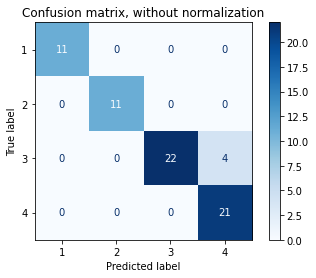

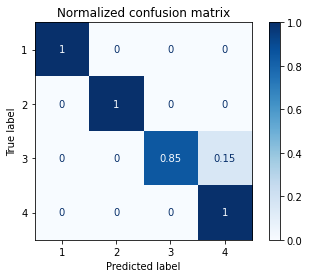

In [28]:
# Confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(rs_rf, X_test, y_test,
                                                 display_labels=[str(x) for x in range(1, 5)],
                                                 cmap=plt.cm.Blues,
                                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

### Kaggle submission

In [19]:
# Read in test_data, remove the 'index' column
test_data = pd.read_csv(r'data\test.csv')
test_data = test_data.drop('index', axis=1)

In [20]:
na_test = test_data.isna().sum()
nan_columns_test = pd.DataFrame(na_test[na_test != 0]).T.columns.tolist() # Retrieve the columns in which nan values are present

# Impute missing values by means of KNearestNeighbours
imr_test = KNNImputer(missing_values=np.nan) 
imr_test = imr_test.fit(test_data[nan_columns_test].values)
imputed_test_val = imr_test.transform(test_data[nan_columns_test].values)

# Copy the test_data and replace the nan_values with the imputed ones
imp_test_data = test_data.copy()
imp_test_data[nan_columns_test] = imputed_test_val

In [21]:
# Convert nominal categorical values to numerical ones
imp_test_data = pd.get_dummies(imp_test_data, drop_first=True)

In [22]:
# Predict the test data with the best model, 
# then convert the results in to a pandas dataframe which in turn 
# is converted to a csv file. 
predictions = lr_gc.predict(imp_test_data)
my_submission = pd.DataFrame({'index': list(range(len(predictions))),
                              'Stage': predictions})
my_submission.to_csv('Submission31.csv', index=False)